# Ch 2. Generalized Linear Models

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import pymc3 as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

## Generalized linear models

## Logistic regression

- GLM with a *logistic function* for the inverse link function
    - the output for any input $z$ will lie within the 0 and 1 interval
    - thus, transforms data for a Bernoulli distribution

$$
\text{logistic}(z) = \frac{1}{1 + e^{-z}}
$$

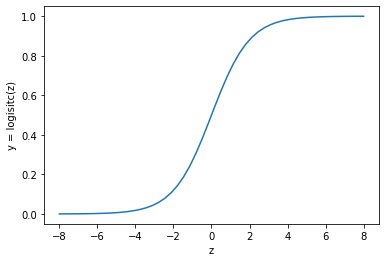

In [2]:
z = np.linspace(-8, 8)
y = 1 / (1 + np.exp(-z))
plt.plot(z, y)
plt.xlabel("z")
plt.ylabel("y = logisitc(z)")
plt.show()

### The logistic model

- same as a linear regression, just using the logistic link function and the Bernoulli likelihood function

$$
\theta = logistic(\alpha + x \beta) \\
y \sim \text{Bernoulli}(\theta)
$$

### The Iris dataset

In [3]:
iris = pd.read_csv("data/iris.csv")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


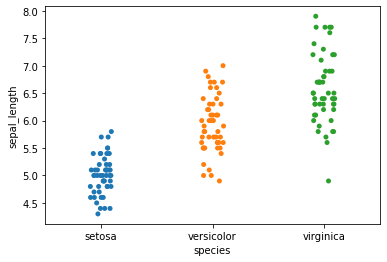

In [4]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=True)
plt.show()

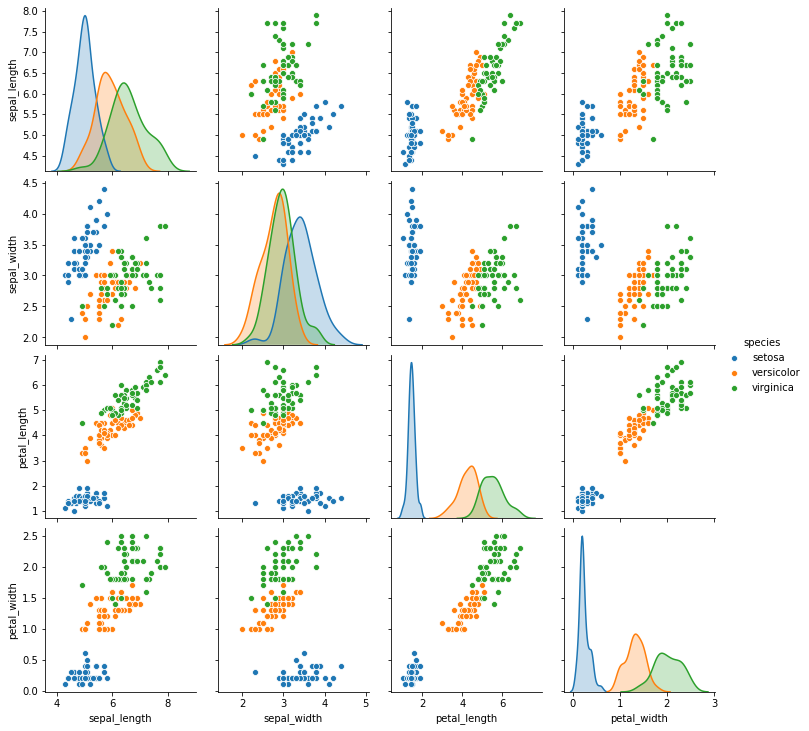

In [5]:
sns.pairplot(iris, hue="species", diag_kind="kde")
plt.show()

#### The logistic model applied to the Iris dataset

- classify `setosa` vs. `versicolor` using `sepal_length` as the only predictor
    - encode the species as 0 and 1, respectively

In [6]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df["species"]).codes
x_n = "sepal_length"
x_0 = df[x_n].values
x_c = x_0 - x_0.mean()  # center the data

- two deterministic variables in this model:
    - `θ`: ouput of the logistic function applied to `µ`
    - `bd`: the "boundary decision" is the value of the predictor variable used to separate classes

In [8]:
with pm.Model() as model_0:
    α = pm.Normal("α", mu=0, sd=10)
    β = pm.Normal("β", mu=0, sd=10)

    µ = α + pm.math.dot(x_c, β)
    θ = pm.Deterministic("θ", pm.math.sigmoid(µ))
    bd = pm.Deterministic("bd", -α / β)

    y1 = pm.Bernoulli("y1", p=θ, observed=y_0)

    trace_0 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β, α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 20 seconds.


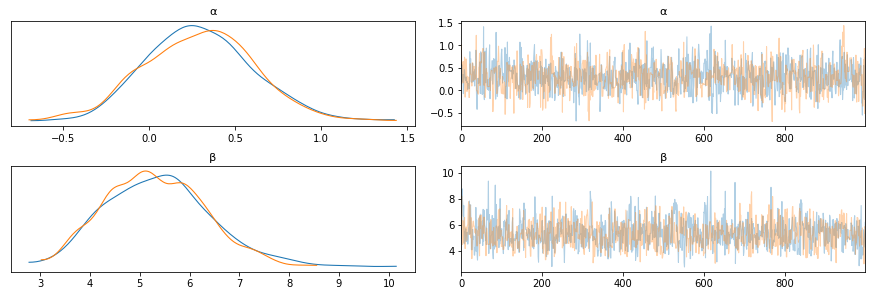

In [11]:
az_trace_0 = az.from_pymc3(trace_0, model=model_0)
az.plot_trace(az_trace_0, var_names=["α", "β"])
plt.show()

In [13]:
az.summary(az_trace_0)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
α,0.296,0.315,-0.282,0.874,0.009,0.007,1253.0,1069.0,1262.0,1255.0,1.0
β,5.353,1.024,3.559,7.250,0.031,0.022,1096.0,1096.0,1094.0,1049.0,1.0
θ[0],0.164,0.057,0.064,0.270,0.002,0.001,1403.0,1403.0,1352.0,1024.0,1.0
θ[1],0.068,0.036,0.014,0.136,0.001,0.001,1377.0,1377.0,1263.0,965.0,1.0
θ[2],0.027,0.020,0.001,0.063,0.001,0.000,1317.0,1317.0,1224.0,1013.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
θ[96],0.812,0.064,0.687,0.920,0.002,0.001,1112.0,1105.0,1101.0,1010.0,1.0
θ[97],0.979,0.018,0.946,0.999,0.001,0.000,1031.0,1029.0,1061.0,1009.0,1.0
θ[98],0.164,0.057,0.064,0.270,0.002,0.001,1403.0,1403.0,1352.0,1024.0,1.0
θ[99],0.812,0.064,0.687,0.920,0.002,0.001,1112.0,1105.0,1101.0,1010.0,1.0


/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


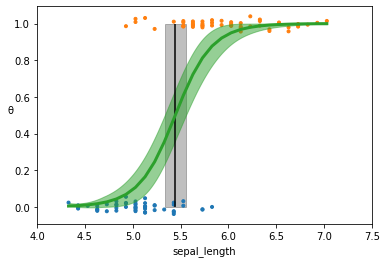

In [28]:
theta = trace_0["θ"].mean(axis=0)
idx = np.argsort(x_c)
plt.plot(x_c[idx], theta[idx], color="C2", lw=3)
plt.vlines(trace_0["bd"].mean(), 0, 1, color="k")
bd_hpi = az.hdi(trace_0["bd"])
plt.fill_between(bd_hpi, 0, 1, color="k", alpha=0.25)
plt.scatter(x_c, np.random.normal(y_0, 0.02), marker=".", color=[f"C{x}" for x in y_0])
az.plot_hdi(x_c, trace_0["θ"], color="C2", ax=plt.gca())

plt.xlabel(x_n)
plt.ylabel("θ", rotation=0)
locs, _ = plt.xticks()
plt.xticks(locs, np.round(locs + x_0.mean(), 1))

plt.show()

## Multiple logistic regression

In [30]:
df = iris.query("species == ('setosa', 'versicolor')")
y_1 = pd.Categorical(df.species).codes
x_n = ["sepal_length", "sepal_width"]
x_1 = df[x_n].values

### The boundary decision

$$
0.5 = \text{logistic}(\alpha + \beta_1 x_1 + \beta_2 x_2) \Leftrightarrow 0 = \alpha + \beta_1 x_1 + \beta_2 x_2 \\
x_2 = - \frac{\alpha}{\beta_2} - \frac{\beta_1}{\beta_2}x_1
$$

### Implementing the model

In [32]:
with pm.Model() as model_1:
    alpha = pm.Normal("alpha", mu=0, sd=10)
    beta = pm.Normal("beta", mu=0, sd=2, shape=len(x_n))

    mu = alpha + pm.math.dot(x_1, beta)
    theta = pm.Deterministic("theta", 1 / (1 + pm.math.exp(-mu)))
    bd = pm.Deterministic(
        "bd", -1.0 * alpha / beta[1] - (x_1[:, 0] * beta[0] / beta[1])
    )

    y1 = pm.Bernoulli("y1", p=theta, observed=y_1)

    trace_1 = pm.sample(2000)

az_trace_1 = az.from_pymc3(trace=trace_1, model=model_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 37 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


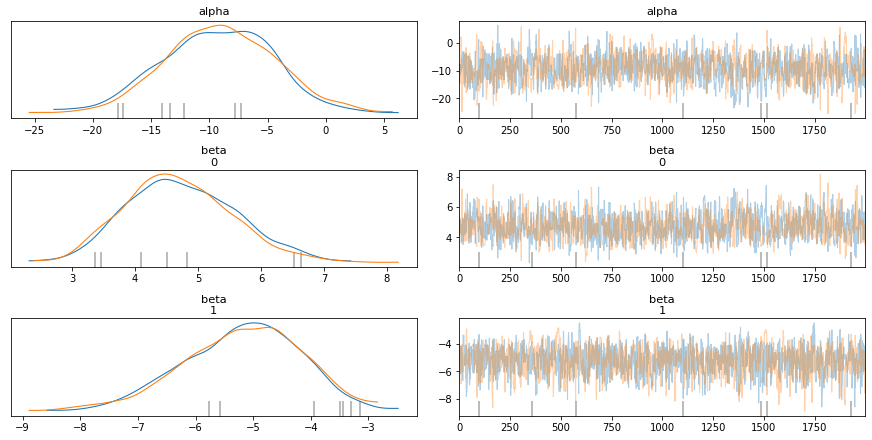

In [34]:
az.plot_trace(az_trace_1, var_names=["alpha", "beta"])
plt.show()

/Users/admin/Developer/Python/bayesian-analysis-with-python_e2/.env/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


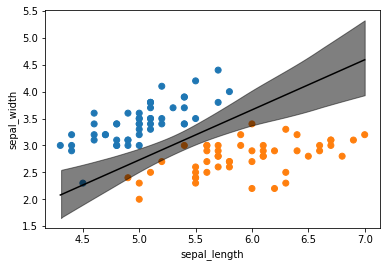

In [36]:
idx = np.argsort(x_1[:, 0])
bd = trace_1["bd"].mean(0)[idx]
plt.scatter(x_1[:, 0], x_1[:, 1], c=[f"C{x}" for x in y_0])
plt.plot(x_1[:, 0][idx], bd, color="k")
az.plot_hdi(x_1[:, 0], trace_1["bd"], color="k", ax=plt.gca())
plt.xlabel(x_n[0])
plt.ylabel(x_n[1])
plt.show()